In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.linalg.interpolative as sli
from matplotlib import pyplot as plt
from tqdm import tqdm, trange
from time import perf_counter

## Define low-rank approximations

### Singular Value Decomposition

In [2]:
def svd(A, k):
    """Computes the optimal deterministic rank-k approximation of the SVD of the input matrix."""
    U, sigma, Vh = np.linalg.svd(A, full_matrices=False)
    Sigma = np.diag(sigma[:k])
    return U[:,:k] @ Sigma @ Vh[:k]

### Orthogonal Projection Interpolative Decompositions

In [3]:
def opid(A, k, col_pivoted=True):
    """Computes a deterministic rank-k approximation of the OPID of the input matrix."""
    
    # if A is (m,n) with m <= n, then Q is (m,m) and R is (m,n)
    
    temp = scipy.linalg.qr(A, pivoting=col_pivoted, mode='economic')  # returns Q, R, P
    Q = temp[0]
        
    Q_k = Q[:,:k]
    approx = Q_k @ Q_k.T @ A
    
    _ = np.linalg.lstsq(A[:,:k], approx, rcond=None)  # compute actual decomposition for accurate time measurement
    
    return approx

In [4]:
def opid_pivot(A, k):
    return opid(A, k, col_pivoted=True)

def opid_nopivot(A, k):
    return opid(A, k, col_pivoted=False)

In [5]:
def random_opid(A, k, oversampling=10, col_pivoted=True, choices=None):
    """Calculates a randomized rank-k approximation of the OPID of the input matrix."""
    
    if oversampling < 0:
        raise ValueError('Oversampling parameter cannot be negative.')
        
    p = k + oversampling
    if p > A.shape[1]:
        raise ValueError('Oversampling parameter is too large.')
    
    if choices is None:
        cols = np.random.choice(A.shape[1], replace=False, size=p)
    else:
        cols = choices
        
    AS = A[:,cols]
    
    temp = scipy.linalg.qr(AS, pivoting=col_pivoted, mode='economic')
    Q = temp[0]

    Q_k = Q[:,:k]  # removes the p-k oversampled columns
    approx = Q_k @ Q_k.T @ A
    
    _ = np.linalg.lstsq(A[:,cols], approx, rcond=None)  # compute actual decomposition for accurate time measurement
    
    return approx

In [6]:
def ropid_op(A, k):
    return random_opid(A, k, oversampling=10, col_pivoted=True)

def ropid_o(A, k):
    return random_opid(A, k, oversampling=10, col_pivoted=False)

def ropid_p(A, k):
    return random_opid(A, k, oversampling=0, col_pivoted=True)

def ropid_none(A, k):
    return random_opid(A, k, oversampling=0, col_pivoted=False)

### SciPy Interpolative Decompositions

In [7]:
def scipy_id(A, k):
    idx, proj = sli.interp_decomp(A, k, rand=False)
    B = sli.reconstruct_skel_matrix(A, k, idx)
    C = sli.reconstruct_matrix_from_id(B, idx, proj)
    return C

def scipy_random_id(A, k):
    idx, proj = sli.interp_decomp(A, k, rand=True)
    B = sli.reconstruct_skel_matrix(A, k, idx)
    C = sli.reconstruct_matrix_from_id(B, idx, proj)
    return C

## Read data

In [8]:
mnist = pd.read_csv('../datasets/mnist/train.csv')

data = mnist[mnist.columns[1:]].values / 255
data = data[:5000]

Transpose the data matrix if necessary --- we want the matrix to be 'wide' not 'tall'.

In [9]:
if data.shape[0] > data.shape[1]:
    data = data.T

In [10]:
data.shape

(784, 5000)

In [11]:
def display_img(A, n):
    choices = np.random.choice(A.shape[1], replace=False, size=n)
    plt.imshow(A[:,choices].reshape(28,28,n).transpose(0,2,1).reshape(28,n*28))

In [12]:
# array.shape = (a,b,c)
# np.transpose(array, (2,0,1)) = (c,a,b)

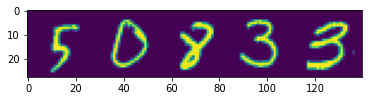

In [13]:
display_img(data, 5)

In [14]:
data_norm = np.linalg.norm(data)

In [15]:
def calculate_error(A):
    return np.linalg.norm(data - A) / data_norm

In [16]:
def stats(A):
    res = np.empty(7)
    
    res[0] = np.quantile(A, 0.25)
    res[1] = np.median(A)
    res[2] = np.quantile(A, 0.75)
    res[3] = np.mean(A)
    res[4] = np.std(A)
    res[5] = np.min(A)
    res[6] = np.max(A)
    
    return np.copy(res)

In [17]:
k_domain = np.arange(10, 490, step=40)
k_len = k_domain.shape[0]

### deterministic methods

In [18]:
DET_ALGS = [svd, scipy_id, opid_pivot, opid_nopivot]
num_det_algs = len(DET_ALGS)

DET_ERRORS = np.empty((num_det_algs, k_len))
DET_TIMES = np.empty((num_det_algs, k_len))

for i, k in enumerate(tqdm(k_domain)):
    for h, alg in enumerate(DET_ALGS):
        start = perf_counter()
        DET_ERRORS[h,i] = calculate_error(alg(data, k))
        DET_TIMES[h,i] = perf_counter() - start

100%|██████████| 12/12 [02:52<00:00, 14.40s/it]


### randomized methods

In [19]:
RAND_ALGS = [scipy_random_id, ropid_op, ropid_o, ropid_p, ropid_none]
# RAND_ALGS = [ropid_op, ropid_o, ropid_p, ropid_none]
num_rand_algs = len(RAND_ALGS)

RAND_ERRORS = np.empty((num_rand_algs, 7, k_len))
RAND_TIMES = np.empty((num_rand_algs, 7, k_len))

iterations = 3 #10

for i, k in enumerate(tqdm(k_domain)):
    errors = np.empty((num_rand_algs, iterations))
    times = np.empty((num_rand_algs, iterations))

    for j in range(iterations):
        for h, alg in enumerate(RAND_ALGS):
            start = perf_counter()
            errors[h,j] = calculate_error(alg(data,k))
            times[h,j] = perf_counter() - start
        
    for h in range(num_rand_algs):
        RAND_ERRORS[h,:,i] = stats(errors[h])
        RAND_TIMES[h,:,i] = stats(times[h])

100%|██████████| 12/12 [07:13<00:00, 36.11s/it]


## Display results

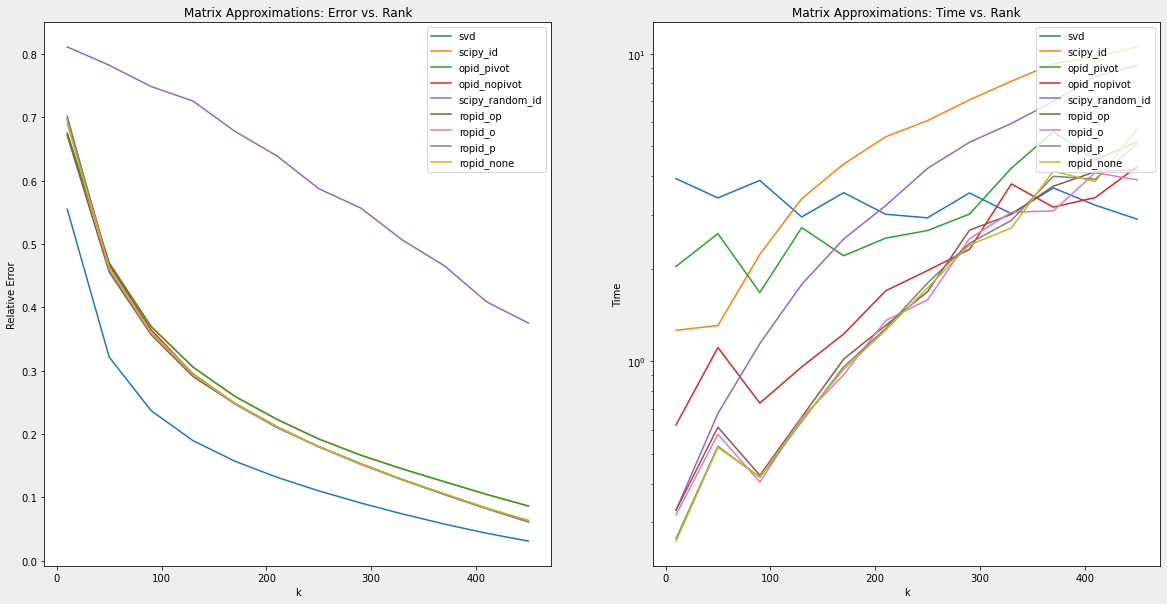

In [20]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
fig.set_facecolor('#EEE')


# ERROR GRAPH
for h, alg in enumerate(DET_ALGS):
    ax[0].plot(k_domain, DET_ERRORS[h], label=alg.__name__)
for h, alg in enumerate(RAND_ALGS):
    ax[0].plot(k_domain, RAND_ERRORS[h,3], label=alg.__name__)

ax[0].set_xlabel('k')
ax[0].set_ylabel('Relative Error')
# ax[0].set_yscale('log')
ax[0].legend(loc='upper right')
ax[0].set_title('Matrix Approximations: Error vs. Rank')


# TIME GRAPH
for h, alg in enumerate(DET_ALGS):
    ax[1].plot(k_domain, DET_TIMES[h], label=alg.__name__)
for h, alg in enumerate(RAND_ALGS):
    ax[1].plot(k_domain, RAND_TIMES[h,3], label=alg.__name__)

ax[1].set_xlabel('k')
ax[1].set_ylabel('Time')
ax[1].set_yscale('log')
ax[1].legend(loc='upper right')
ax[1].set_title('Matrix Approximations: Time vs. Rank');

### Test to see if low-rank approximation preserves $k$ columns.

In [21]:
temp_k = 200

In [22]:
func = random_opid

In [23]:
cols = np.random.choice(data.shape[1], replace=False, size=temp_k)
approx = func(data, temp_k, choices=cols)

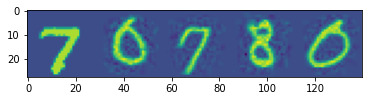

In [24]:
display_img(approx, 5)

In [25]:
eps = 0.00000001

print(f'{np.sum(approx > eps) / approx.size:.1%} of entries are greater than {eps}.')

44.3% of entries are greater than 1e-08.


In [26]:
print(f'The average value of an entry is {np.mean(approx):.4f}.')

The average value of an entry is 0.1311.


In [27]:
assert np.allclose(approx[:,cols], data[:,cols]), "This low-rank approximation was not formed from an ID."

In [28]:
np.linalg.matrix_rank(approx, tol=0.001)

200

In [29]:
np.linalg.matrix_rank(data, tol=0.001)

646

### Try to recreate the decomposition from the approximation.

In [30]:
C = approx[:,cols]

In [31]:
ls_res = np.linalg.lstsq(C, approx, rcond=None)
Z = ls_res[0]
print(f'Worst LS residual: {max(ls_res[1])}')

Worst LS residual: 8.552680274321914e-29


In [32]:
assert np.allclose(C @ Z, approx), "The decomposition was not formed accurately."

In [33]:
print(f'All the elements in Z are bounded by {np.max(np.abs(Z))}.')

All the elements in Z are bounded by 1.036970159047018.
